# Importing Packages Needed

In [63]:
import numpy as np

In [64]:
import scipy as sp

In [65]:
import matplotlib.pyplot as py

In [66]:
from scipy.optimize import curve_fit

In [67]:
from scipy.signal import find_peaks

In [68]:
import collections as col

# Definition of Named Tuples

In [69]:
component = col.namedtuple('component','phase intensity')

In [70]:
ind_component = col.namedtuple('component','phase intensity width')

In [71]:
pulse_component = col.namedtuple('pulse_component','frequency comp1 comp2, errors')

In [72]:
component_separation = col.namedtuple('component_separation','frequency separation')

# Definition of Functions

Gaussian Fitting Functions:

In [73]:
def gauss(x,cen,sd,amp):
    return amp*np.exp(-(x-cen)**2/2/sd**2)

def threegauss(x,cen1,sd1,amp1,cen2,sd2,amp2,cen3,sd3,amp3):
    return gauss(x,cen1,sd1,amp1)+gauss(x,cen2,sd2,amp2)+gauss(x,cen3,sd3,amp3)

In [74]:
def fitting_parameters(x,y,expected):
    params,cov=curve_fit(threegauss,x,y,expected)
    sigma=np.sqrt(np.diag(cov))
    return params, sigma

def gauss_fit(x,params):
    return threegauss(x,*params)

Finding Peak of Fittings Function

In [75]:
def gauss_peaks(fit, nofreqband, freqband, sigma):
    status='starting'
  
    i=3
    peakpos = find_peaks(fit, prominence=i, distance=50, height=i)[0]

    while len(peakpos) !=2 and i>=1 and i<5:
        if len(peakpos) < 2:
            i=i-0.5
            peakpos = find_peaks(fit, prominence=i, distance=50, height=1)[0]

        elif len(peakpos) > 2:
            i=i+0.5
            peakpos = find_peaks(fit, prominence=i, distance=50, height=2)[0]
    
  #Can be used for error checking
  #else:
    #print('Loop done')
    #print(i)

    if len(peakpos) == 2:
        status='pending'

        if peakpos[0]>=300 and peakpos[0]<=535 and peakpos[1]>=650 and peakpos[1]<=800:
            status='complete'
        
        else:
            status='error'

    else:
        status='error'


    if status=='complete':
        component1 = component(phase=(360/1024)*peakpos[0], intensity=fit[peakpos[0]])
        component2 = component(phase=(360/1024)*peakpos[1], intensity=fit[peakpos[1]])
        errors = sigma
  
    elif status=='error':
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        errors = 0

    else:
        print("Error: Something not complete in peak finding")

    freq=(((500-300)/nofreqband)*(nofreqband-freqband))+300 

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=sigma)

  #Can be used for error checking
  #if status != 'error':
    #plot_peaks(x,y,profile_comp)

    return profile_comp

In [76]:
def ind_peaks(params, nofreqband, freqband, sigma):
    status='starting'
    uncert=[]

    if params[0]<params[3] and params[0]<params[6] and params[0]>=300 and params[0]<=535:
        component1 = ind_component(phase=(360/1024)*params[0], intensity=params[1], width=params[2])
        uncert.extend((sigma[0], sigma[1], sigma[2]))
        status='complete'
    elif params[3]<params[0] and params[3]<params[6] and params[3]>=300 and params[3]<=535:
        component1 = ind_component(phase=(360/1024)*params[3], intensity=params[4], width=params[5])
        uncert.extend((sigma[3], sigma[4], sigma[5]))
        status='complete'
    elif params[6]<params[0] and params[6]<params[3] and params[6]>=300 and params[6]<=535:
        component1 = ind_component(phase=(360/1024)*params[6], intensity=params[7], width=params[8])
        uncert.extend((sigma[6], sigma[7], sigma[8]))
        status='complete'
    else:
        component1 = ind_component(phase=0, intensity=0, width=0)
        uncert.extend((0,0,0))
        status='error'

    if params[0]>params[3] and params[0]>params[6] and params[0]>=650 and params[0]<=800:
        component2 = ind_component(phase=(360/1024)*params[0], intensity=params[1], width=params[2])
        uncert.extend((sigma[0], sigma[1], sigma[2]))
        status='complete'
    elif params[3]>params[0] and params[3]>params[6] and params[3]>=650 and params[3]<=800:
        component2 = ind_component(phase=(360/1024)*params[3], intensity=params[4], width=params[5])
        uncert.extend((sigma[3], sigma[4], sigma[5]))
        status='complete'
    elif params[6]>params[0] and params[6]>params[3] and params[6]>=650 and params[6]<=800:
        component2 = ind_component(phase=(360/1024)*params[6], intensity=params[7], width=params[8])
        uncert.extend((sigma[6], sigma[7], sigma[8]))
        status='complete'
    else:
        component2 = ind_component(phase=0, intensity=0, width=0)
        uncert.extend((0,0,0))
        status='error'

    freq=(((500-300)/nofreqband)*(nofreqband-freqband))+300 

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=uncert)

  #Can be used for error checking
  #if status != 'error':
    #plot_peaks(x,y,profile_comp)

    return profile_comp

Plotting Fittings Functions

In [77]:
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

In [78]:
def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    params3 = params[6:9]
    gfit1 = gauss(x, *params1)
    gfit2 = gauss(x, *params2)
    gfit3 = gauss(x, *params3)


    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
  
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)

    py.plot(x, gfit3, "b")
    py.fill_between(x, gfit3.min(), gfit3, facecolor="blue", alpha=0.5)

    return 

In [79]:
def plot_peaks(x,y,profile_comp):
    py.plot(x,y, lw=0.5)
    py.plot(x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Separation Data

In [80]:
def separation_singleprofile(components_array, array_wuncert):
    sep_array=[]
    uncert=[]

    for i in range(0,len(components_array)):
        if components_array[i][1][0] != 0 and components_array[i][2][0] != 0:
    
            freq=components_array[i][0]
            sep=(components_array[i][2][0]) - (components_array[i][1][0])

            single_sep=component_separation(frequency=freq, separation=sep)

            sep_array.append(single_sep)

            uncert.append(np.sqrt((array_wuncert[i][3][0])**2 + (array_wuncert[i][3][3])**2))
      
    return sep_array, uncert

In [81]:
def powerlaw(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)

# Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

In [82]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [83]:
averageprofiles = np.loadtxt(fname='../archivefiles/com_archivefiles/pdv/J0820_s_f28_T_pazi.pdv', dtype=fulldatatype)

In [84]:
no_freq_bands = max(averageprofiles['frequency'])+1

# Gaussian Plotting of Individual Frequency Band - Used for error checking individual frequency bands

Choosing Frequency Band. Following Section is for error checking:

In [143]:
freqband = 72
f = averageprofiles['frequency'] == freqband

In [144]:
phase=averageprofiles['phase'][f]
intensity=averageprofiles['intensity'][f]

Gaussian Plots

In [145]:
x = phase
y = intensity

In [146]:
len(y)

1024

In [147]:
#Taken from Peaks and Gaussian fittings of frequency band 73
expected=(501,30,8.02,655,80,4.07,741,20,11.29)

In [148]:
params,sigma = fitting_parameters(x,y,expected)
fit = gauss_fit(x, params)
profile_comp = gauss_peaks(fit,no_freq_bands,freqband,sigma)

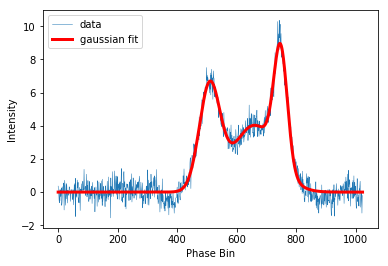

In [149]:
plot_fit(x,y,fit,params,sigma)

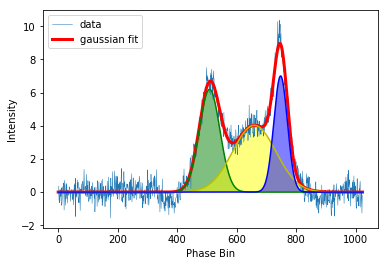

In [150]:
plot_fill(x,y,params)

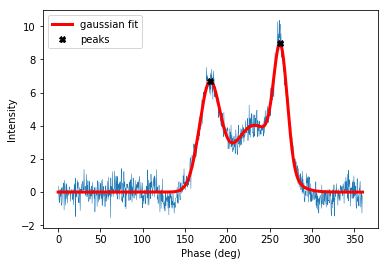

In [151]:
plot_peaks(x*(360/1024),y,profile_comp)

In [94]:
profile_comp

pulse_component(frequency=453.42465753424653, comp1=component(phase=181.7578125, intensity=3.473903829007336), comp2=component(phase=261.5625, intensity=4.552704663166683), errors=array([0.82241721, 0.95558505, 0.07998413, 4.13201629, 3.35543749,
       0.04105977, 0.56207144, 0.72643597, 0.08850646]))

# Gaussian Plotting and Finding Peaks of Overall Fit Data (fit_components) and Individual Fit Data (ind_components)


The following is a looped version of the previous section to find the correct peaks for each pulse profile

In [95]:
fit_components = []
ind_components=[]

In [96]:
#Taken from Peaks and Gaussian fittings of frequency band 73, in the middle
expected=(501,30,8.02,655,80,4.07,741,20,11.29)

for i in range(0,no_freq_bands):
    freqband = i
  
  #Can be used for error checking
  #print(freqband)

    f = averageprofiles['frequency'] == freqband

    x=averageprofiles['phase'][f]
    y=averageprofiles['intensity'][f]

    if len(x)!=0 and len(y)!=0:
        params,sigma = fitting_parameters(x,y,expected)
        fit = gauss_fit(x, params)
        profile_comp = gauss_peaks(fit, no_freq_bands, freqband, sigma)
        profile_ind = ind_peaks(params, no_freq_bands, freqband, sigma)

    #Can be used for error checking
    #print(profile_comp)
  
        fit_components.append(profile_comp)
        ind_components.append(profile_ind)

# Change of Peak Position over Frequency

## Fit Peaks (fit_components)

Starting to graph out all the movement of component phase across frequency

---



In [97]:
phase_comp1=[]
frequency_comp1=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    phase_comp1.append(fit_components[i][1][0])
    frequency_comp1.append(fit_components[i][0])

Text(0,0.5,'Frequency')

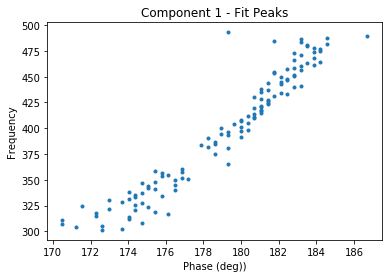

In [98]:
py.plot(phase_comp1,frequency_comp1, '.')
py.title('Component 1 - Fit Peaks')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

In [99]:
phase_comp2=[]
frequency_comp2=[]

for i in range(0,len(fit_components)):
  if fit_components[i][2][0] != 0:
    phase_comp2.append(fit_components[i][2][0])
    frequency_comp2.append(fit_components[i][0])

Text(0,0.5,'Frequency')

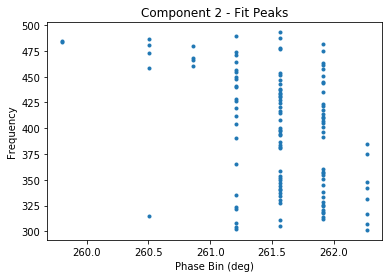

In [100]:
py.plot(phase_comp2,frequency_comp2, '.')
py.title('Component 2 - Fit Peaks')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

## Individual Peaks (ind_components)

In [101]:
phase_ind1=[]
frequency_ind1=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    phase_ind1.append(ind_components[i][1][0])
    frequency_ind1.append(ind_components[i][0])

Text(0,0.5,'Frequency')

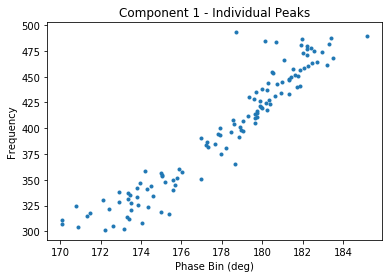

In [102]:
py.plot(phase_ind1,frequency_ind1, '.')
py.title('Component 1 - Individual Peaks')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [103]:
phase_ind2=[]
frequency_ind2=[]

for i in range(0,len(ind_components)):
  if ind_components[i][2][0] != 0:
    phase_ind2.append(ind_components[i][2][0])
    frequency_ind2.append(ind_components[i][0])

Text(0,0.5,'Frequency')

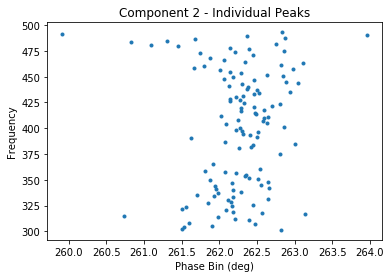

In [104]:
py.plot(phase_ind2,frequency_ind2, '.')
py.title('Component 2 - Individual Peaks')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

# Component Separation Across Frequency 

## Fit Peaks (fit_components)

In [105]:
component_sep, sep_error = separation_singleprofile(fit_components, ind_components)

In [106]:
comp_sep=[]
frequency_forsep=[]

#range(0,no_freq_bands)
for i in range(0,len(component_sep)):
  comp_sep.append(component_sep[i][1])
  frequency_forsep.append(component_sep[i][0])

Text(0,0.5,'Δθ (deg)')

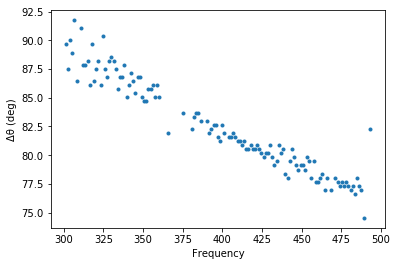

In [107]:
py.plot(frequency_forsep, comp_sep, '.')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

## Individual Peaks (ind_components)

In [108]:
component_sep_ind, ind_sep_errors= separation_singleprofile(ind_components, ind_components)

In [109]:
comp_sep_ind=[]
frequency_forsep_ind=[]

#range(0,no_freq_bands)
for i in range(0,len(component_sep_ind)):
  comp_sep_ind.append(component_sep_ind[i][1])
  frequency_forsep_ind.append(component_sep_ind[i][0])

Text(0,0.5,'Δθ (deg)')

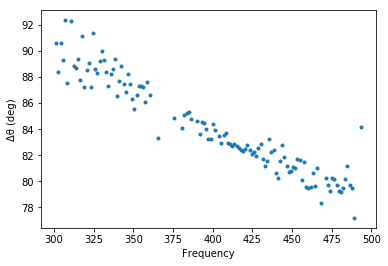

In [110]:
py.plot(frequency_forsep_ind, comp_sep_ind, '.')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

# Fitting Power Laws to Separation 

## Fit Peaks (fit_components)

In [111]:
#To use in weightings: sigma=inv_var
inv_var = []

for i in range(len(sep_error)):
  temp = 1/(sep_error[i]*sep_error[i])
  inv_var.append(temp)

In [112]:
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(powerlaw,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,0],[1000,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))

In [113]:
print(sep_params)
print(sep_fit_error)
separation_fit = powerlaw(frequency_forsep, *sep_params)

[ 5.82451413e+02 -3.27141649e-01  3.85101272e-06]
[6.25408285e+02 3.71285814e-01 9.43719238e+01]


Text(0,0.5,'Δθ (deg)')

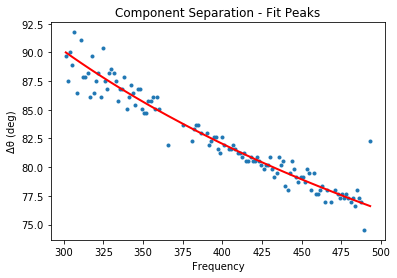

In [114]:
py.plot(frequency_forsep, comp_sep, '.', label='data')
py.plot(frequency_forsep,separation_fit, color='red',lw=2,label='power fit')
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [115]:
chi, p = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 582.451 ν^-0.327 + 0.000 

The errors are 625.408, 0.371, 94.372 
The chi squared value for the fit is:  1.560384941745078
Units for Δθ is degrees and ν is MHz


## Individual Peaks (ind_components)

In [116]:
#To use in weightings: sigma=inv_var_ind
inv_var_ind = []

for i in range(len(ind_sep_errors)):
  temp = 1/(ind_sep_errors[i]*ind_sep_errors[i])
  inv_var_ind.append(temp)

In [117]:
expect=(200,0.5,50)
sep_params_ind,sep_cov_ind=curve_fit(powerlaw,frequency_forsep_ind,comp_sep_ind, expect, maxfev=1000000,sigma=inv_var_ind,bounds=([0,-1,0],[1000,0.5,np.inf]))
sep_fit_error_ind=np.sqrt(np.diag(sep_cov_ind))

In [118]:
print(sep_params_ind)
separation_fit_ind = powerlaw(frequency_forsep, *sep_params_ind)

[ 1.0000000e+03 -5.8878134e-01  5.4747550e+01]


Text(0,0.5,'Δθ (deg)')

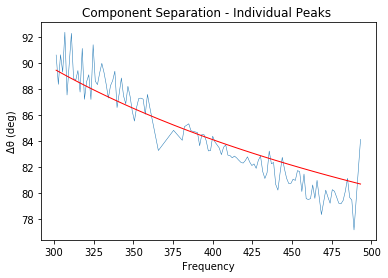

In [119]:
py.plot(frequency_forsep_ind, comp_sep_ind, lw=0.5, label='data')
py.plot(frequency_forsep_ind,separation_fit_ind, color='red',lw=1,label='power fit')
py.title('Component Separation - Individual Peaks ')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [120]:
chi_ind, p_ind = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params_ind[0]:.3f} \u03BD^{sep_params_ind[1]:.3f} + {sep_params_ind[2]:.3f} \n')
print(f'The errors are {sep_fit_error_ind[0]:.3f}, {sep_fit_error_ind[1]:.3f}, {sep_fit_error_ind[2]:.3f} ')
print('The chi squared value for the fit is: ', chi_ind)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 1000.000 ν^-0.589 + 54.748 

The errors are 5073.155, 1.190, 60.049 
The chi squared value for the fit is:  1.560384941745078
Units for Δθ is degrees and ν is MHz


# Change in Intensity over Frequency

## Fit Peaks (fit_components)

In [121]:
intensity_comp1=[]
frequency_comp1=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp1.append(fit_components[i][1][1])
    frequency_comp1.append(fit_components[i][0])

Text(0,0.5,'Intensity')

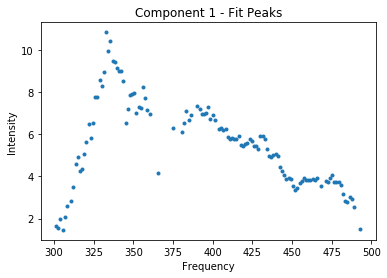

In [122]:
py.plot(frequency_comp1,intensity_comp1, '.')
py.title('Component 1 - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

In [123]:
intensity_comp2=[]
frequency_comp2=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp2.append(fit_components[i][2][1])
    frequency_comp2.append(fit_components[i][0])

Text(0,0.5,'Intensity')

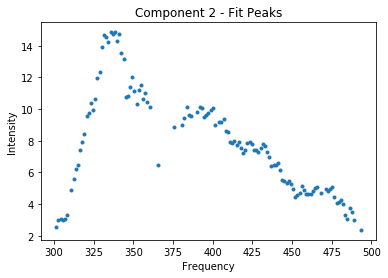

In [124]:
py.plot(frequency_comp2,intensity_comp2, '.')
py.title('Component 2 - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

## Individual Peaks (ind_components)

In [125]:
intensity_ind1=[]
frequency_ind1=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    intensity_ind1.append(ind_components[i][1][1])
    frequency_ind1.append(ind_components[i][0])

Text(0,0.5,'Intensity')

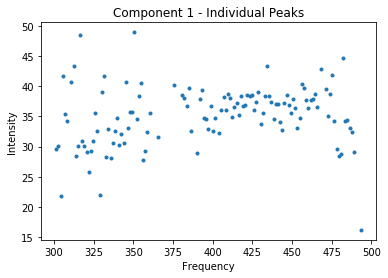

In [126]:
py.plot(frequency_ind1,intensity_ind1, '.')
py.title('Component 1 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

In [127]:
intensity_ind2=[]
frequency_ind2=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    intensity_ind2.append(ind_components[i][2][1])
    frequency_ind2.append(ind_components[i][0])

Text(0,0.5,'Intensity')

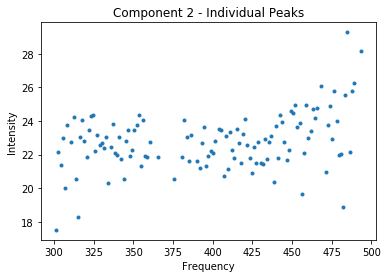

In [128]:
py.plot(frequency_ind2,intensity_ind2, '.')
py.title('Component 2 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

# Intensity Fitting

In [129]:
int1_params,int1_cov=curve_fit(powerlaw,frequency_ind1,intensity_ind1, maxfev=10000)
int1_error=np.sqrt(np.diag(int1_cov))

In [130]:
int1_fit = powerlaw(frequency_ind1, *int1_params)

Text(0,0.5,'Δθ (deg)')

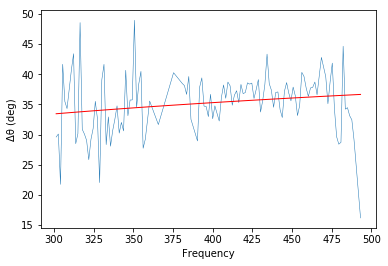

In [131]:
py.plot(frequency_ind1, intensity_ind1, lw=0.5, label='data')
py.plot(frequency_ind1, int1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [132]:
int2_params,int2_cov=curve_fit(powerlaw,frequency_ind2,intensity_ind2, maxfev=10000)
int2_error=np.sqrt(np.diag(int2_cov))

In [133]:
int2_fit = powerlaw(frequency_ind2, *int2_params)

Text(0,0.5,'Δθ (deg)')

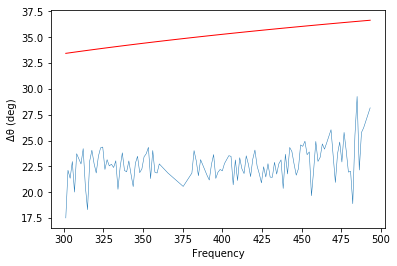

In [134]:
py.plot(frequency_ind2, intensity_ind2, lw=0.5, label='data')
py.plot(frequency_ind2, int1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

# Change in Width over Frequency

In [135]:
width_ind1=[]
frequency_ind1=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    width_ind1.append(ind_components[i][1][2])
    frequency_ind1.append(ind_components[i][0])

Text(0,0.5,'Width (deg)')

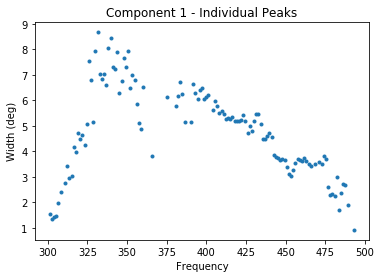

In [136]:
py.plot(frequency_ind1,width_ind1, '.')
py.title('Component 1 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Width (deg)')

In [137]:
width_ind2=[]
frequency_ind2=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    width_ind2.append(ind_components[i][2][2])
    frequency_ind2.append(ind_components[i][0])

Text(0,0.5,'Width (deg)')

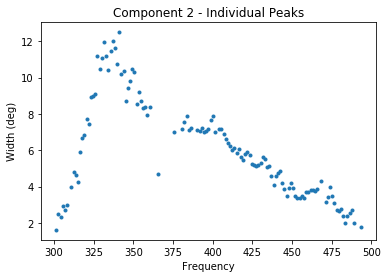

In [138]:
py.plot(frequency_ind2,width_ind2, '.')
py.title('Component 2 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Width (deg)')

# Width Fitting

In [139]:
wid1_params,wid1_cov=curve_fit(powerlaw,frequency_ind1,width_ind1, maxfev=10000)
wid1_error=np.sqrt(np.diag(wid1_cov))

In [140]:
wid1_fit = powerlaw(frequency_ind1, *wid1_params)

Text(0,0.5,'Δθ (deg)')

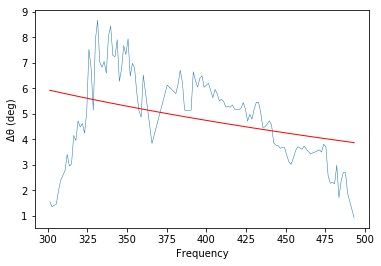

In [141]:
py.plot(frequency_ind1, width_ind1, lw=0.5, label='data')
py.plot(frequency_ind1,wid1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [142]:
wid2_params,wid2_cov=curve_fit(powerlaw,frequency_ind2,width_ind2, maxfev=10000)
wid2_error=np.sqrt(np.diag(wid2_cov))

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

In [ ]:
wid2_fit = powerlaw(frequency_ind2, *wid2_params)

In [ ]:
py.plot(frequency_ind2, width_ind2, lw=0.5, label='data')
py.plot(frequency_ind2, wid2_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')